<a href="https://colab.research.google.com/github/namuhuchutong/SpoilerDetection-test/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/




# --- init ----



In [ ]:
!pip install pyLDAvis==2.1.2

import pandas as pd
import numpy as np
import re
import nltk
import statistics
import pyLDAvis
import pyLDAvis.gensim
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.manifold import TSNE
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model

     |████████████████████████████████| 1.6MB 3.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=63aba9fb5d6f91137018226a8289dee232227d67619c3d34d52ef5718c819489
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [ ]:
df_details = pd.read_json('/content/gdrive/MyDrive/Colab Notebooks/dataset/IMDB_movie_details.json', lines=True)
df_reviews = pd.read_json('/content/gdrive/MyDrive/Colab Notebooks/dataset/IMDB_reviews.json', lines=True)

In [ ]:
print("details : " + str(df_details.shape))
print("reviews : " + str(df_reviews.shape))

df_details.head()

details : (1572, 7)
reviews : (573913, 7)


,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


In [ ]:
df_reviews.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


### tt0468569 == Dark Knight
### tt0111161 == The Shawshank Redemption 

In [ ]:
df_reviews['movie_id'].value_counts()

tt0468569    4845
tt0111161    4361
tt0167260    2729
tt0137523    2480
tt0068646    2137
             ... 
tt0107719      12
tt6294822      11
tt0104014       5
tt0201265       4
tt0114142       2
Name: movie_id, Length: 1572, dtype: int64

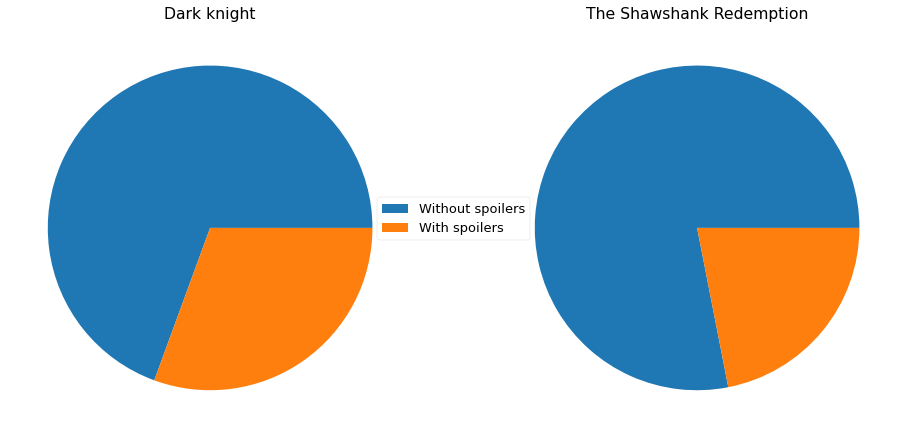

In [ ]:
df_reviews[df_reviews['movie_id'] == 'tt0468569']['is_spoiler'].value_counts()

pie1 = df_reviews[df_reviews['movie_id'] == 'tt0468569']['is_spoiler'].value_counts().reset_index().sort_values(by='index')
pie2 = df_reviews[df_reviews['movie_id'] == 'tt0111161']['is_spoiler'].value_counts().reset_index().sort_values(by='index')

with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(16, 8))

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.pie(pie1['is_spoiler'])
    ax1.set_title('Dark knight')

    ax2.pie(pie2['is_spoiler'])
    ax2.set_title('The Shawshank Redemption')

    fig.legend(labels=['Without spoilers', 'With spoilers'], loc='center')

    plt.show()

# Tf-idf



In [ ]:
def add_plot(review, detail, movie_id):

  tfidf = review[review['movie_id'] == movie_id][['user_id', 'is_spoiler', 'review_text']].copy()

  plot = pd.DataFrame(detail.loc[detail['movie_id'] == movie_id]['plot_synopsis'])
  plot['is_spoiler'] = True
  plot['user_id'] = 'plot'
  plot = plot.rename({'plot_synopsis':'review_text'}, axis='columns')
  tfidf = tfidf.append(plot).reset_index()
  del tfidf['index']
  return tfidf

tfidf_dk = add_plot(df_reviews, df_details, 'tt0468569')
tfidf_sh = add_plot(df_reviews, df_details, 'tt0111161')

In [ ]:
print(tfidf_dk.shape, tfidf_dk.tail())
print(tfidf_sh.shape, tfidf_sh.tail())

(4846, 3)          user_id  is_spoiler                                        review_text
4841  ur12459428       False  Yeah, I saw The Dark Knight yesterday night; t...
4842  ur15981877       False  Just saw the movie. I had a lot of expectation...
4843  ur13888972       False  Batman has human weaknesses and is still a sup...
4844  ur14463537       False  If the last Batman film made you want to be in...
4845        plot        True  The movie begins with a gang of men with clown...
(4362, 3)         user_id  is_spoiler                                        review_text
4357  ur0819902       False  With all due respect to the people that compla...
4358  ur0562732       False  Every single scene in The Shawshank Redemption...
4359  ur2693433       False  At the beginning i thought, this would be an a...
4360  ur0365713       False  In years to come the Shawshank Redemtion will ...
4361       plot        True  In 1947, Andy Dufresne (Tim Robbins), a banker...


In [ ]:
stemmer = SnowballStemmer("english", ignore_stopwords=False)
nltk.download('punkt')
def normalize(X): 
  normalized = []
  for x in X:
    words = nltk.word_tokenize(x)
    normalized.append(' '.join([stemmer.stem(word) for word in words if re.match('[a-zA-Z]+', word)]))
  return normalized

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
pipe = Pipeline([
  ('normalize', FunctionTransformer(normalize, validate=False)),
  ('counter_vectorizer', CountVectorizer(
    max_df=0.8, max_features=100,
    min_df=0.2, stop_words='english',
    ngram_range=(1,2)
  )),
  ('tfidf_transform', TfidfTransformer())
])

tfidf_dk_matrix = pipe.fit_transform([x for x in tfidf_dk['review_text']])
tfidf_sh_matrix = pipe.fit_transform([x for x in tfidf_sh['review_text']])

In [ ]:
similarity_distance_dk = 1 - cosine_similarity(tfidf_dk_matrix)
similarity_distance_sh = 1 - cosine_similarity(tfidf_sh_matrix)

In [ ]:
def find_similar(reviews, similarity_distance, user):
  index = reviews[reviews['user_id'] == user].index[0]
  vector = similarity_distance[index, :]
  print(vector)
  print(np.argsort(vector))
  most_similar = reviews.iloc[np.argsort(vector)[1], :]
  return most_similar, np.argsort(vector)

most, dk_list = find_similar(tfidf_dk, similarity_distance_dk, 'plot')
most, sh_list = find_similar(tfidf_sh, similarity_distance_sh, 'plot')

[ 4.45583946e-01  6.65314379e-01  6.95722266e-01 ...  5.62577633e-01
  7.50834586e-01 -2.22044605e-16]
[4845  546 1411 ...  891 4385 1228]
[ 5.50403792e-01  4.63656956e-01  4.95607882e-01 ...  9.61629862e-01
  8.54427255e-01 -2.22044605e-16]
[4361 4012 2470 ... 1186  552 1675]


In [ ]:
def show_me(df, sorted):
  for i, x in enumerate(sorted):
    if i > 11:
      break
    print(df.iloc[x, :])
    print('-'*50)


In [ ]:
print("dark knight : " + str(tfidf_dk_matrix.shape))
print("Shawshank : " + str(tfidf_dk_matrix.shape))

dark knight : (4846, 81)
Shawshank : (4846, 81)


In [ ]:
show_me(tfidf_dk, dk_list)

user_id                                                     plot
is_spoiler                                                  True
review_text    The movie begins with a gang of men with clown...
Name: 4845, dtype: object
--------------------------------------------------
user_id                                                ur2446936
is_spoiler                                                  True
review_text    If Batman is the untamed world, The Joker is t...
Name: 546, dtype: object
--------------------------------------------------
user_id                                               ur21256558
is_spoiler                                                  True
review_text    Nolan has don it again batman, except he broug...
Name: 1411, dtype: object
--------------------------------------------------
user_id                                                ur5291991
is_spoiler                                                  True
review_text    Christopher Nolan steps back into the di

In [ ]:
def plot_show(df, sorted):
  a = np.arange(len(sorted))
  b = []
  for x in sorted:
    if df.iloc[x]['is_spoiler'] == True:
      b.append(1)
    else:
      b.append(0)

  new_s = pd.Series(data = b, index = a)
  new_s.plot(figsize=(70, 30))
  print(new_s[:20])

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     0
8     1
9     0
10    1
11    1
12    0
13    1
14    1
15    1
16    0
17    1
18    1
19    1
dtype: int64


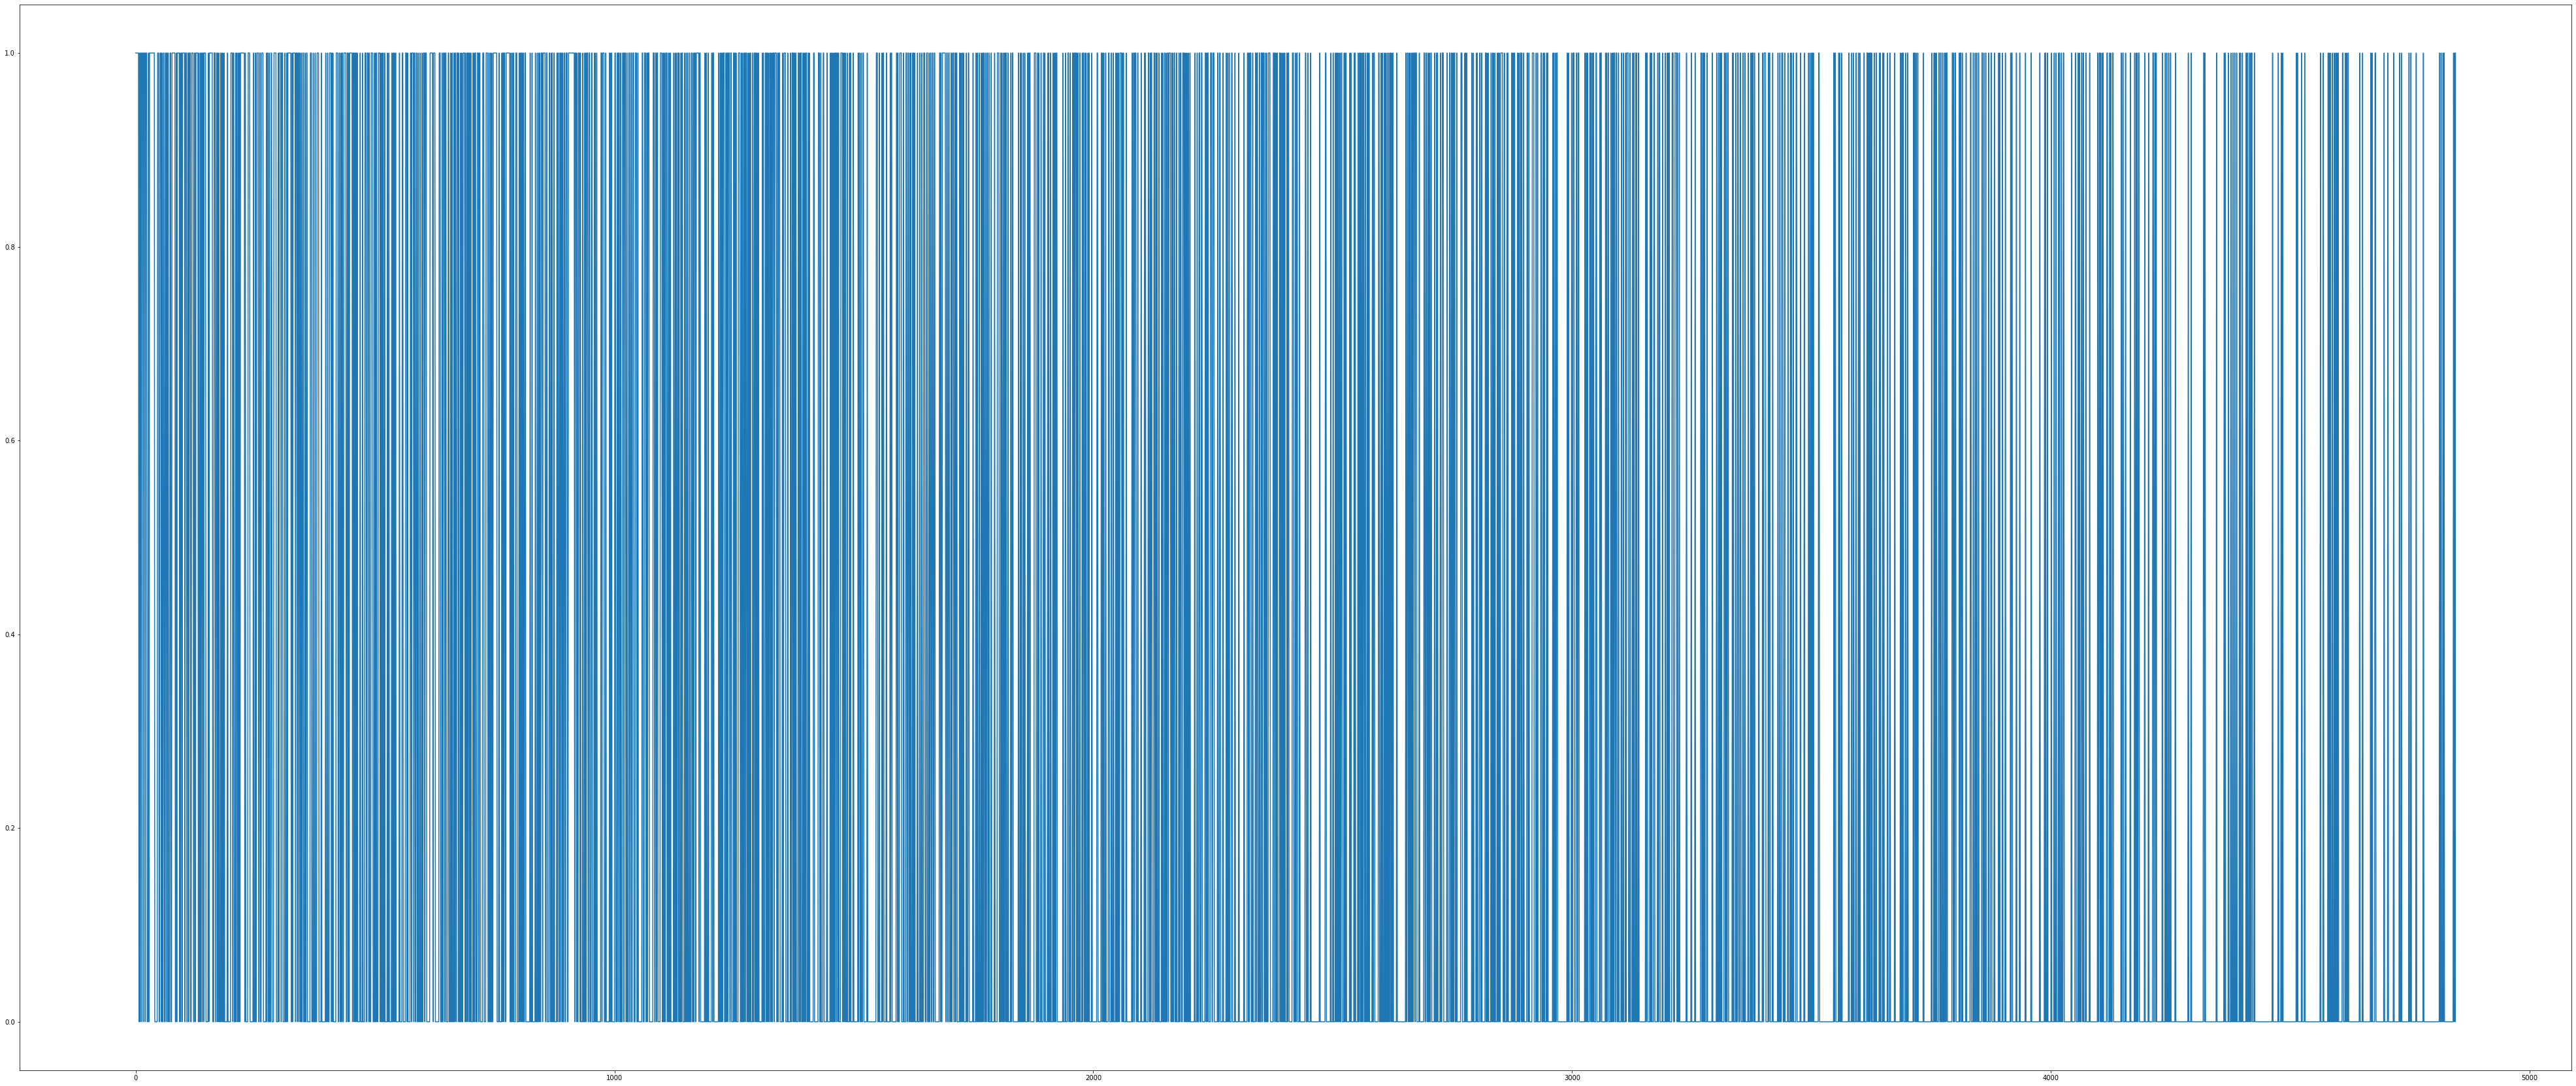

In [ ]:
plot_show(tfidf_dk, dk_list)

0     1
1     0
2     0
3     0
4     1
5     0
6     1
7     0
8     0
9     1
10    1
11    1
12    1
13    0
14    1
15    1
16    1
17    1
18    1
19    1
dtype: int64


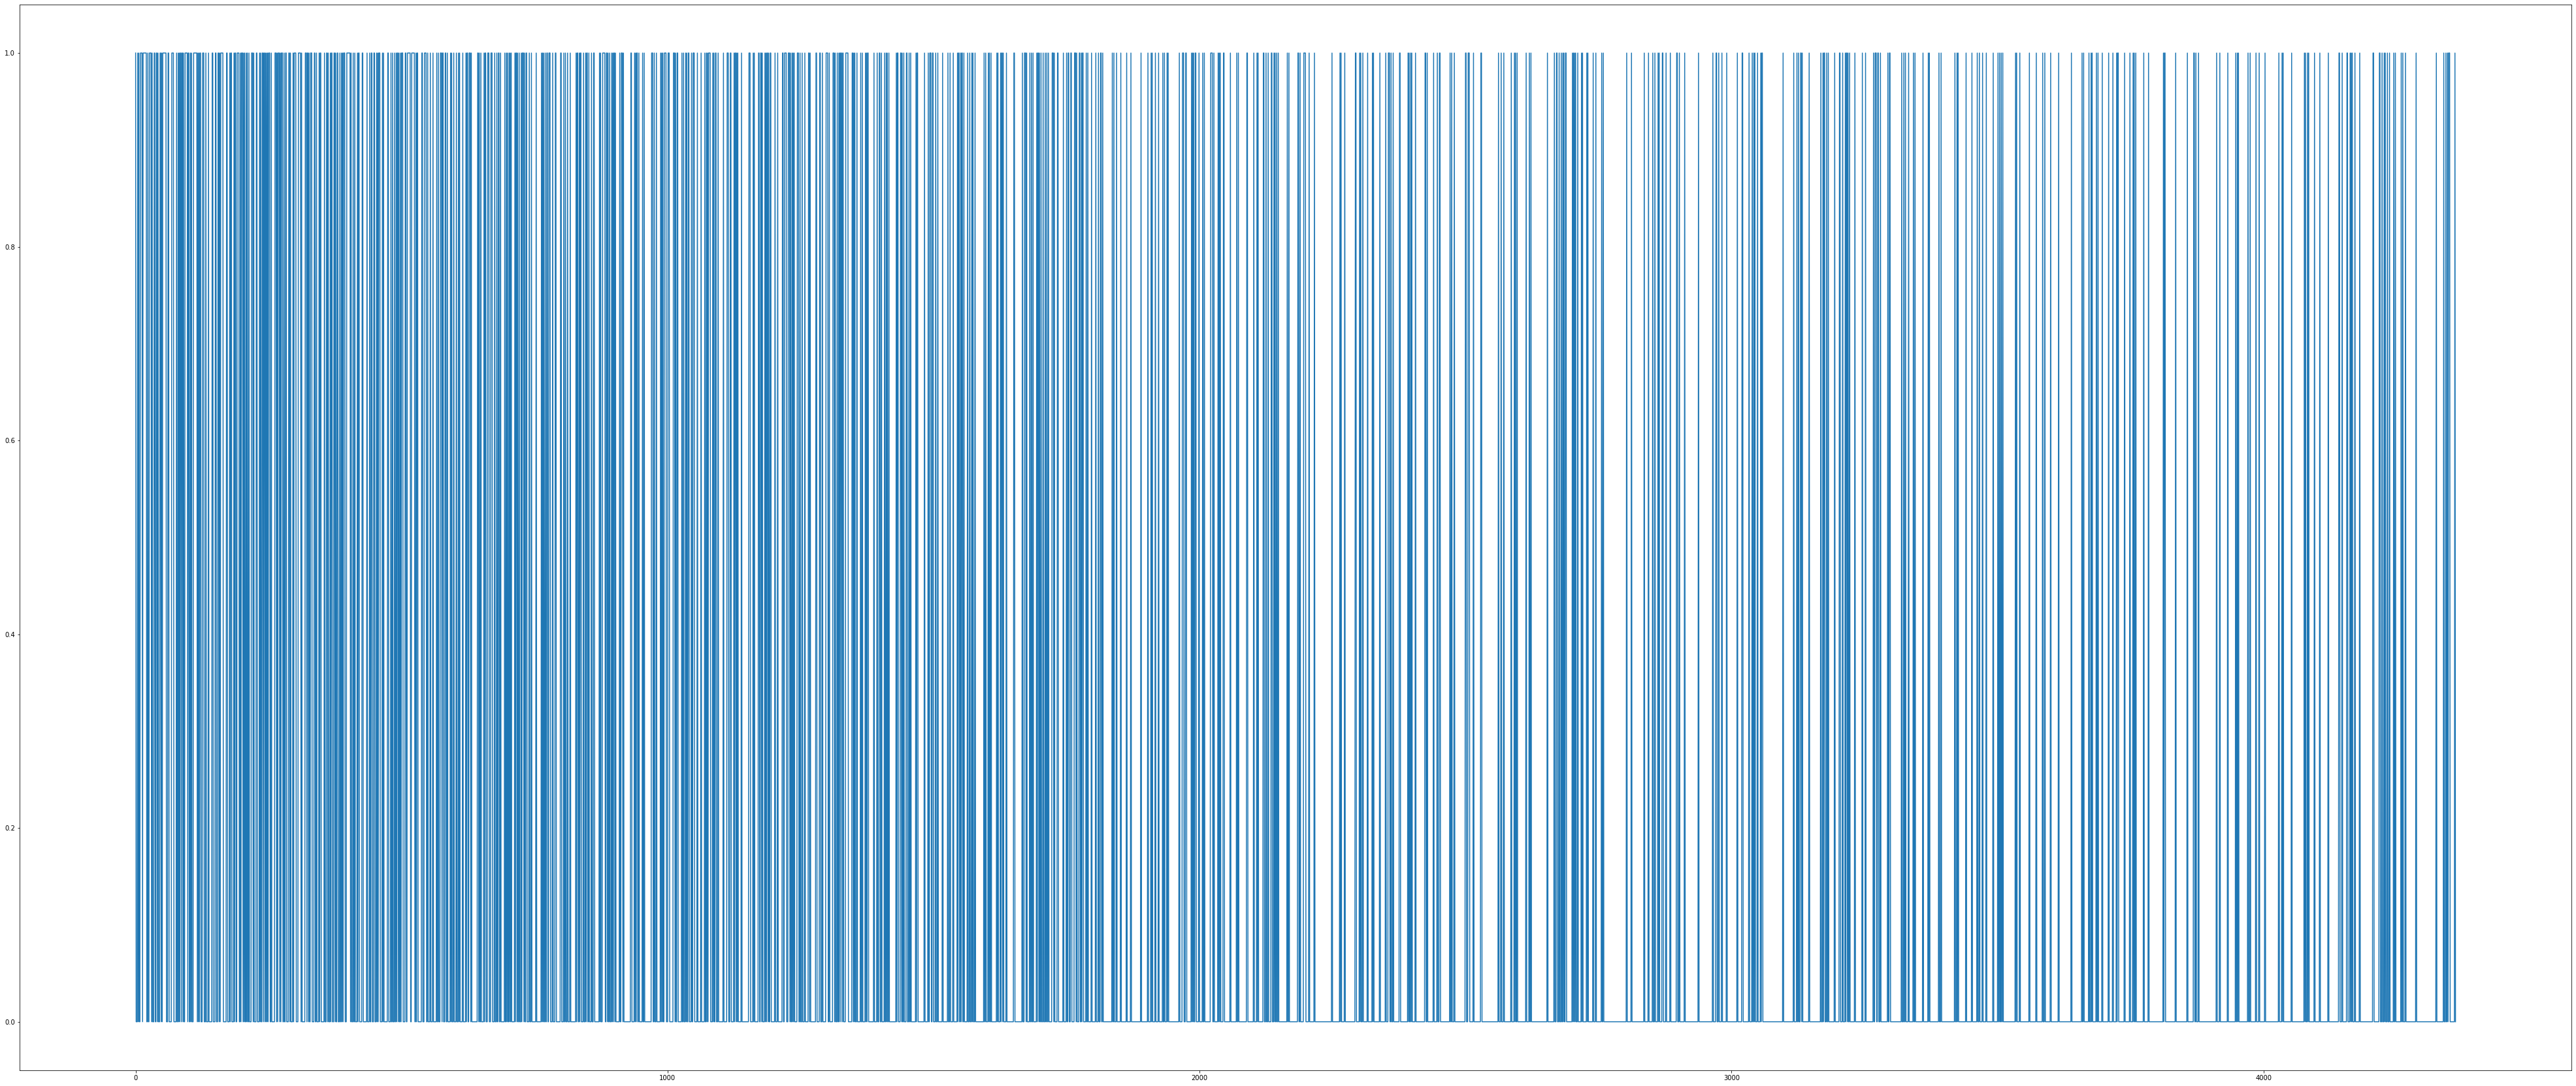

In [ ]:
plot_show(tfidf_sh, sh_list)

# NMF

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
pipe2 = Pipeline([
  ('normalize', FunctionTransformer(normalize, validate=False)),
  ('counter_vectorizer', CountVectorizer(
    max_df=0.8, max_features=200000,
    min_df=0.2, stop_words='english',
    ngram_range=(1,2)
  ))])

tf_dk = pipe2.fit_transform([x for x in tfidf_dk['review_text']])

In [ ]:
tf_sh = pipe2.fit_transform([x for x in tfidf_sh['review_text']])

In [ ]:
nmf_dk= NMF(random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf_dk_matrix)

In [ ]:
dk = normalize([x for x in tfidf_dk['review_text']])

In [ ]:
tf_vectorizer = TfidfVectorizer(max_df=0.8, 
                                max_features=200000,
                                min_df=0.2, stop_words='english',
                                ngram_range=(1,2))
tfidf1 = tf_vectorizer.fit_transform(dk)
tfidf_feature_names = tf_vectorizer.get_feature_names()

In [ ]:
!pip install pyLDAvis==2.1.2

# LDA

In [ ]:
import gensim
from tensorflow.keras.preprocessing.text import text_to_word_sequence

/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [ ]:
tfidf_dk['review_text'] = tfidf_dk['review_text'].apply(lambda x: text_to_word_sequence(x))
tfidf_sh['review_text'] = tfidf_sh['review_text'].apply(lambda x: text_to_word_sequence(x))

In [ ]:
bi_dk = gensim.models.Phrases(tfidf_dk['review_text'])
bi_dk_mod = gensim.models.phrases.Phraser(bi_dk)
bigram = [bi_dk_mod[review] for review in tfidf_dk['review_text']]
id2word_dk = gensim.corpora.Dictionary(bigram)
id2word_dk.filter_extremes(no_below=10, no_above=0.35)
id2word_dk.compactify()
corpus_dk = [id2word_dk.doc2bow(text) for text in bigram]

In [ ]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train_dk = gensim.models.ldamulticore.LdaMulticore(
                           corpus=corpus_dk,
                           num_topics=15,
                           id2word=id2word_dk,
                           chunksize=100,
                           workers=7,
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)
    lda_train_dk.save('lda_train.model')

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_train_dk, corpus_dk, id2word_dk)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.180018  0.050886       1        1  22.130073
11     0.129621 -0.007963       2        1  19.742264
2      0.078566  0.034062       3        1  18.542928
1      0.060149 -0.022602       4        1  16.209192
10     0.063600 -0.038210       5        1   9.915718
6      0.184611  0.059147       6        1   7.144055
5      0.071560  0.067813       7        1   1.878084
12     0.114440 -0.054096       8        1   1.045203
14    -0.126179  0.226700       9        1   0.942626
7     -0.033976 -0.317094      10        1   0.864421
8     -0.042844  0.018790      11        1   0.547357
0     -0.163519 -0.040110      12        1   0.417460
4     -0.172959 -0.028228      13        1   0.282712
9     -0.120180  0.018946      14        1   0.201812
3     -0.222908  0.031958      15        1   0.136096, topic_info=                Term         Freq        Total Category  logprob  loglift
103              him  3091.000000  3091.000000  Default  30.0000  30.0000
138               me  2460.000000  2460.000000  Default  29.0000  29.0000
678             ever  1868.000000  1868.000000  Default  28.0000  28.0000
448   christian_bale  1829.000000  1829.000000  Default  27.0000  27.0000
17           because  2707.000000  2707.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
108            humor     4.047080   206.914592  Topic15  -5.3603   2.6653
5545      interested     3.148449    86.170761  Topic15  -5.6114   3.2901
5575         trilogy     3.410643   330.380744  Topic15  -5.5314   2.0262
884             soon     3.208363   204.414503  Topic15  -5.5925   2.4452
638              boy     2.919649   110.989927  Topic15  -5.6868   2.9616

[1101 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2322      2  0.314185         '
2322      3  0.141383         '
2322      4  0.322040         '
2322      5  0.031419         '
2322      9  0.141383         '
...     ...       ...       ...
2803      7  0.072480  yourself
2803      8  0.080533  yourself
4443      3  0.653421         
4443      4  0.285569         
4443      8  0.058082         

[3148 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 12, 3, 2, 11, 7, 6, 13, 15, 8, 9, 1, 5, 10, 4])

In [ ]:
bi_sh = gensim.models.Phrases(tfidf_sh['review_text'])
bi_sh_mod = gensim.models.phrases.Phraser(bi_dk)
bigram = [bi_sh_mod[review] for review in tfidf_sh['review_text']]
id2word_sh = gensim.corpora.Dictionary(bigram)
id2word_sh.filter_extremes(no_below=10, no_above=0.35)
id2word_sh.compactify()
corpus_sh = [id2word_sh.doc2bow(text) for text in bigram]

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train_sh = gensim.models.ldamulticore.LdaMulticore(
                           corpus=corpus_sh,
                           num_topics=15,
                           id2word=id2word_sh,
                           chunksize=100,
                           workers=7,
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)
    lda_train_sh.save('lda_train.model')

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_train_sh, corpus_sh, id2word_sh)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.164546  0.122081       1        1  19.320642
8     -0.067241  0.080002       2        1  16.623650
4     -0.190607  0.049307       3        1  14.333053
10     0.138655  0.134427       4        1  10.754022
0     -0.161898  0.018748       5        1   9.065737
12    -0.072025 -0.138382       6        1   6.274770
2      0.252776  0.017877       7        1   4.203771
5     -0.139716 -0.119035       8        1   3.738466
1     -0.170580  0.105267       9        1   3.529795
13     0.123684  0.125465      10        1   2.965047
6     -0.094725 -0.242499      11        1   2.269457
3      0.094425 -0.057235      12        1   2.018538
9      0.239604 -0.060722      13        1   1.783291
7      0.075630  0.124934      14        1   1.636011
11     0.136565 -0.160235      15        1   1.483750, topic_info=        Term         Freq        Total Category  logprob  loglift
116       he  4890.000000  4890.000000  Default  30.0000  30.0000
23      andy  3931.000000  3931.000000  Default  29.0000  29.0000
109     good  2192.000000  2192.000000  Default  28.0000  28.0000
229      red  2143.000000  2143.000000  Default  27.0000  27.0000
143     king   980.000000   980.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
109     good    56.351671  2192.087219  Topic15  -4.6580   0.5496
229      red    55.050504  2143.341081  Topic15  -4.6814   0.5487
23      andy    58.035947  3931.343899  Topic15  -4.6285  -0.0051
718  freeman    44.563355   459.071235  Topic15  -4.8927   1.8783
324      who    45.776470  1852.955244  Topic15  -4.8658   0.5098

[1152 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
339      13  0.892376        '90's
3564      6  0.947103        'rita
1         5  0.964994  'shawshank'
1831      6  0.818618         'the
1831      9  0.180483         'the
...     ...       ...          ...
650      12  0.009827         your
650      14  0.034941         your
1248      5  0.954704    your_seat
338       5  0.162388  zihuatanejo
338       7  0.829981  zihuatanejo

[2989 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 9, 5, 11, 1, 13, 3, 6, 2, 14, 7, 4, 10, 8, 12])

In [ ]:
train_vecs_dk = []
for i in range(len(tfidf_dk)):
    top_topics = lda_train_dk.get_document_topics(corpus_dk[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(15)]
    topic_vec.extend([len(tfidf_dk.iloc[i].review_text)])
    train_vecs_dk.append(topic_vec)

In [ ]:
train_vecs_sh = []
for i in range(len(tfidf_sh)):
    top_topics = lda_train_dk.get_document_topics(corpus_sh[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(15)]
    topic_vec.extend([len(tfidf_sh.iloc[i].review_text)])
    train_vecs_sh.append(topic_vec)

# Classifier

In [ ]:
X = np.array(train_vecs_dk)
y = np.array(tfidf_dk.is_spoiler)
y = y.astype(np.float64)

In [ ]:
kf = KFold(5, shuffle=True, random_state=42)
lr_f1 = []

for train_ind, val_ind in kf.split(X, y):

  X_train, y_train = X[train_ind], y[train_ind]
  X_val, y_val = X[val_ind], y[val_ind]
  
  scaler = StandardScaler()
  X_train_scale = scaler.fit_transform(X_train)
  X_val_scale = scaler.transform(X_val)

  lr = LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_scale, y_train)

  y_pred = lr.predict(X_val_scale)
  lr_f1.append(f1_score(y_val, y_pred, average='binary'))

print(f'Logistic Regression Val f1: {np.mean(lr_f1):.3f} +- {np.std(lr_f1):.3f}')

Logistic Regression Val f1: 0.523 +- 0.032


In [ ]:
X = np.array(train_vecs_sh)
y = np.array(tfidf_sh.is_spoiler)
y = y.astype(np.float64)

In [ ]:
kf = KFold(5, shuffle=True, random_state=42)
clr_f1 = []

for train_ind, val_ind in kf.split(X, y):

  X_train, y_train = X[train_ind], y[train_ind]
  X_val, y_val = X[val_ind], y[val_ind]
  
  scaler = StandardScaler()
  X_train_scale = scaler.fit_transform(X_train)
  X_val_scale = scaler.transform(X_val)

  lr = LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_scale, y_train)

  y_pred = lr.predict(X_val_scale)
  clr_f1.append(f1_score(y_val, y_pred, average='binary'))

print(f'Logistic Regression Val f1: {np.mean(clr_f1):.3f} +- {np.std(clr_f1):.3f}')

Logistic Regression Val f1: 0.388 +- 0.024


# 50 : 50

In [ ]:
def get_part_data(df, num_reviews):
  num_pos_reviews = df['is_spoiler'].sum()

  fraction_pos = num_reviews/num_pos_reviews  
  fraction_neg = num_reviews/(df.shape[0] - num_pos_reviews)


  df_pos = df[df['is_spoiler'] == True]['review_text'].sample(frac = fraction_pos, random_state = 2)
  df_neg = df[df['is_spoiler'] == False]['review_text'].sample(frac = fraction_neg, random_state = 2)

  reviews = pd.concat([df_pos, df_neg])
  reviews = reviews.reset_index(drop=True)
  labels = [1]*(num_reviews*2)
  print(len(labels))
  labels[num_reviews:] = [0]*num_reviews

  return reviews, labels

In [ ]:
dk_partion, dk_labels = get_part_data(tfidf_dk, 1000)



2000


0